## Predictive models
Analyses concerning the relation between linguistic features and engagement.

In [15]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl
import xgboost
import shap
from sklearn.preprocessing import RobustScaler
from src.colnames import topic_col, style_col

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})

### Results of predictive models

Visualizing performance in terms of R^2, MSE, and MAE

In [3]:
d = json.load(open('logs/engagement/perf_norm.json'))

In [4]:
d

[{'train_mse': 0.00283372195433937,
  'train_mae': 0.01773593649348609,
  'train_r2': 0.25454409756895036,
  'val_mse': 0.0023715150502115283,
  'val_mae': 0.018743108800927583,
  'val_r2': 0.07116086714193992,
  'test_mse': 0.0015966750670910886,
  'test_mae': 0.018043910877992564,
  'test_r2': 0.09453612352433038,
  'model': 'combined'}]

Computing rank correlations between predictions and true engagement values (gives an idea of how well the model understands which tweets will get more attention, without its predictions being necessarily numerically accurate)

In [5]:
dfs = []
# for metric in ['sum']:
fs = glob.glob(f'logs/engagement/results_norm/pred*.pkl')
for f in fs:
    f_df = pd.read_pickle(f)
    f_df['metric'] = 'sum_count'
    dfs.append(f_df)
metrics = pd.concat(dfs, ignore_index=True)

In [6]:
metrics

,trial_id,label,prediction,model_name,split,metric
0,Congratulations to the winners of Juvenes @tra...,0.012692,0.010564,combined,test,sum_count
1,Do you #commute between 2 EU countries?Find ou...,0.007420,0.014534,combined,test,sum_count
2,Watch live - President @BarrosoEU speech at LS...,0.016501,0.029539,combined,test,sum_count
3,Preparation of #Economic and #Finance Minister...,0.005323,0.009542,combined,test,sum_count
4,.@BarrosoEU to speak tomorrow at @LSEpubliceve...,0.003726,0.014336,combined,test,sum_count
...,...,...,...,...,...,...
17164,#AfricaTrustFund launched by @JunckerEU at #Va...,0.029350,0.011835,combined,val,sum_count
17165,Press release: #teamJunckerEU orientation deba...,0.008158,0.012012,combined,val,sum_count
17166,#VallettaSummit | @EU_Commission represented b...,0.018152,0.011663,combined,val,sum_count
17167,#teamJunckerEU to discuss #deepeningEMU today....,0.006527,0.013908,combined,val,sum_count


In [7]:
spears = metrics.groupby(['metric', 'split',
                          'model_name'])[['label', 
                                          'prediction']].apply(lambda x: x.corr('spearman').iloc[0,1]).reset_index()
spears = spears.rename({0: 'spearman_cor'}, axis=1)

In [8]:
spears

,metric,split,model_name,spearman_cor
0,sum_count,test,combined,0.392563
1,sum_count,train,combined,0.399388
2,sum_count,val,combined,0.366018


Load the model and SHAP values

In [24]:
with xgboost.config_context(verbosity=0):
    m = f'logs/engagement/results_norm/model.pkl'
    name = m.split('/')[-1]
    model = pkl.load(open(m, 'rb'))
    feature_names = topic_col + style_col
    df = pd.DataFrame(zip(model.feature_importances_,
                          feature_names), 
                      columns=['importance', 'feature'])
    df = df.sort_values(by='importance')
    shaps = pkl.load(open(f'logs/engagement/results_norm/shap.pkl','rb'))
    shaps.feature_names = feature_names

Visualize model parameters

In [26]:
model.get_xgb_params()

{'objective': 'reg:tweedie',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1,
 'device': None,
 'eval_metric': None,
 'gamma': 1.0,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.2,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': 10,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': 20,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'tweedie_variance_power': 1.3}

Process SHAP values and visualize

In [27]:
shaps_df = pd.DataFrame(shaps.values.T)
shaps_df['feature_name'] = feature_names
shaps_long = shaps_df.melt(id_vars='feature_name')
norm_data = RobustScaler().fit_transform(shaps.data)
shaps_df_data = pd.DataFrame(norm_data.T)
shaps_df_data['feature_name'] = feature_names
shaps_long_data = shaps_df_data.melt(id_vars='feature_name')
shaps_long['data'] = shaps_long_data['value']
shaps_long['data_simple'] = np.select([(shaps_long['data']<0), 
                                       (shaps_long['data']==0), 
                                       (shaps_long['data']>0)], 
                                      ['low', 'zero', 'high'])

In [28]:
sort_shaps = shaps_long.groupby('feature_name')['value'].agg(lambda x: x.abs().mean()).reset_index().sort_values('value',
                                                                                                                 ascending=False)

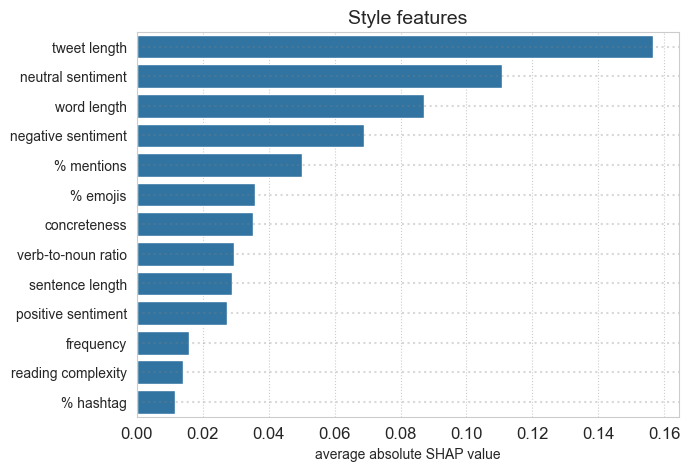

In [29]:
plt.subplots(figsize=(7,5))
for i in range(len(style_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
sns.barplot(data=sort_shaps[sort_shaps['feature_name'].isin(style_col)],
            x='value', y='feature_name', color=sns.color_palette()[0])
plt.xlabel('average absolute SHAP value')
plt.ylabel('')
plt.xticks(fontsize=12)
plt.title('Style features', fontsize=14)
plt.savefig('figs/xgb/style_imp_norm.png', dpi=300, bbox_inches='tight')

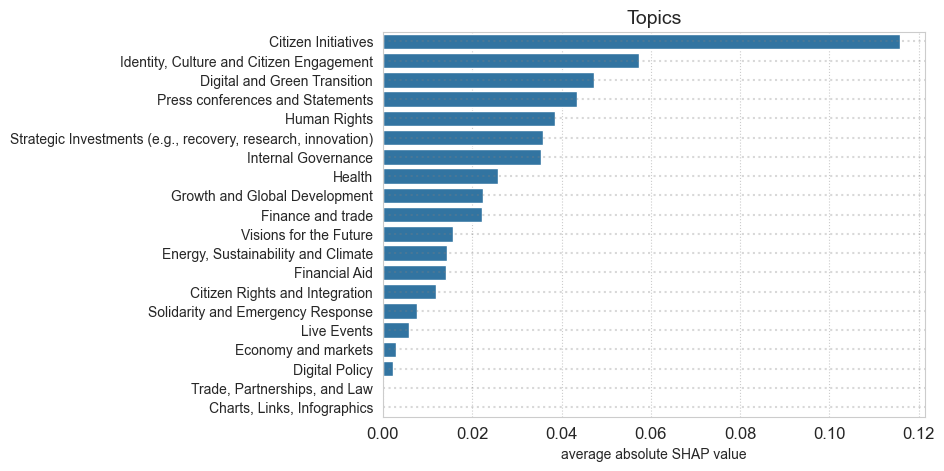

In [30]:
plt.subplots(figsize=(7,5))
for i in range(len(topic_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
sns.barplot(data=sort_shaps[sort_shaps['feature_name'].isin(topic_col)],
            x='value', y='feature_name', color=sns.color_palette()[0])
plt.xlabel('average absolute SHAP value')
plt.ylabel('')
plt.xticks(fontsize=12)
plt.title('Topics', fontsize=14)
plt.savefig('figs/xgb/topic_imp_norm.png', dpi=300, bbox_inches='tight')

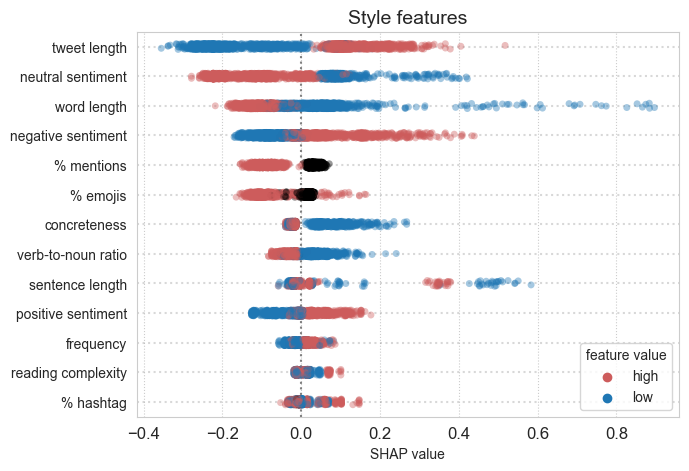

In [31]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
plt.subplots(figsize=(7,5))
data = shaps_long[shaps_long['feature_name'].isin(style_col)]
data = data.merge(sort_shaps, on='feature_name').sort_values(by='value_y', ascending=False)
for i in range(len(style_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
plt.axvline(0, color='grey', linestyle='dotted')
sns.stripplot(data=data,
             y='feature_name', x='value_x', 
                hue='data_simple', palette=['indianred', 
                                            sns.color_palette()[0]],
                hue_order=['high', 'low'],
                alpha=.4)
plt.legend(title='feature value', loc='lower right')
plt.ylabel('')
plt.xlabel('SHAP value')
plt.xticks(fontsize=12)
plt.title('Style features', fontsize=14)
plt.savefig('figs/xgb/style_SHAP_norm.png', dpi=300, bbox_inches='tight')
plt.show()

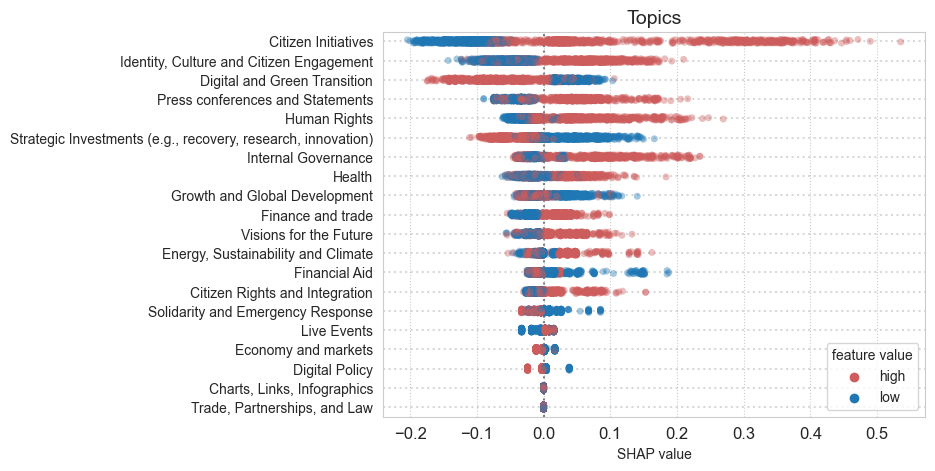

In [32]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
plt.subplots(figsize=(7,5))
data = shaps_long[shaps_long['feature_name'].isin(topic_col)]
data = data.merge(sort_shaps, on='feature_name').sort_values(by='value_y', ascending=False)
for i in range(len(topic_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
plt.axvline(0, color='grey', linestyle='dotted')
sns.stripplot(data=data[data['data_simple']!='zero'],
             y='feature_name', x='value_x', 
             hue='data_simple', palette={'high': 'indianred',
                                         'low': sns.color_palette()[0]},
             alpha=.4)
plt.legend(title='feature value', loc='lower right')
plt.ylabel('')
plt.xlabel('SHAP value')
plt.xticks(fontsize=12)
plt.title('Topics', fontsize=14)

plt.savefig('figs/xgb/topic_SHAP_norm.png', dpi=300, bbox_inches='tight')
plt.show()